# Final Experiment (Binary Classification)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, precision_recall_curve, PrecisionRecallDisplay
from tensorflow.keras.models import load_model
from pathlib import Path

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, load_fusioned_dataset
from src.lib.time_series_augmentation.utils.augmentation import jitter, rotation
from src.models.CNNLSTM import CNNLSTM
from src.models.RCNN import RCNN
from src.lib.DeepStack.deepstack.base import KerasMember
from src.lib.DeepStack.deepstack.ensemble import DirichletEnsemble

In [2]:
kf = KFold(n_splits=10, shuffle=True, random_state=48)
epochs = 100

cnnlstm_auc = []
rcnn_auc = []

In [3]:
model_path = Path(os.path.abspath('')).parent / 'models' / 'saved'

## 1. Unimodal Body (Skeleton Pose Estimation)

In [4]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(783, 1, 350, 35) (783, 1)
(274, 1, 350, 35) (274, 1)


### 1.1 CNN + BiLSTM

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_body_model = CNNLSTM(n_features, None, n_length, n_outputs)
    history = cnnlstm_binary_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_binary_body_model.save(model_path / 'body_binary_cnnlstm.h5')

#### Training performance

In [ ]:
body_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_cnnlstm_train_results

#### Validation performance

In [ ]:
body_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_cnnlstm_val_results

#### Predictions and performance on test set

In [ ]:
cnnlstm_binary_body_model = load_model(model_path / 'body_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_body_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 1.2 RCNN

Epoch 1/100
29/29 - 10s - loss: 0.8063 - accuracy: 0.5795 - auc: 0.6027 - precision: 0.5714 - recall: 0.5481 - f1_score: 0.6552 - val_loss: 2.8856 - val_accuracy: 0.5316 - val_auc: 0.4910 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.6379 - 10s/epoch - 330ms/step
Epoch 2/100
29/29 - 7s - loss: 0.6206 - accuracy: 0.6804 - auc: 0.7350 - precision: 0.6799 - recall: 0.6501 - f1_score: 0.6552 - val_loss: 3.9804 - val_accuracy: 0.5316 - val_auc: 0.4704 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.6379 - 7s/epoch - 237ms/step
Epoch 3/100
29/29 - 7s - loss: 0.6249 - accuracy: 0.6889 - auc: 0.7475 - precision: 0.6890 - recall: 0.6589 - f1_score: 0.6552 - val_loss: 0.9846 - val_accuracy: 0.5063 - val_auc: 0.6110 - val_precision: 0.4848 - val_recall: 0.8649 - val_f1_score: 0.6379 - 7s/epoch - 230ms/step
Epoch 4/100
29/29 - 7s - loss: 0.5861 - accuracy: 0.7173 - auc: 0.7795 - precision: 0.7156 - recall: 0.6968 - f1_score: 0.6552 - val_loss: 1.4004

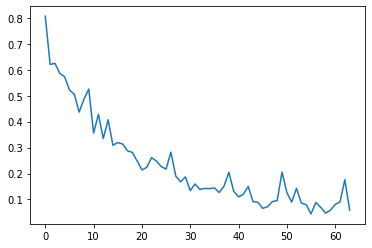

Epoch 1/100
29/29 - 10s - loss: 0.7748 - accuracy: 0.5781 - auc_1: 0.5981 - precision_1: 0.5623 - recall_1: 0.5473 - f1_score: 0.6488 - val_loss: 3.1268 - val_accuracy: 0.5316 - val_auc_1: 0.6004 - val_precision_1: 0.5316 - val_recall_1: 1.0000 - val_f1_score: 0.6942 - 10s/epoch - 341ms/step
Epoch 2/100
29/29 - 7s - loss: 0.6338 - accuracy: 0.6662 - auc_1: 0.7197 - precision_1: 0.6537 - recall_1: 0.6479 - f1_score: 0.6488 - val_loss: 1.5592 - val_accuracy: 0.5316 - val_auc_1: 0.7516 - val_precision_1: 0.5316 - val_recall_1: 1.0000 - val_f1_score: 0.6942 - 7s/epoch - 242ms/step
Epoch 3/100
29/29 - 7s - loss: 0.6086 - accuracy: 0.6747 - auc_1: 0.7491 - precision_1: 0.6764 - recall_1: 0.6183 - f1_score: 0.6488 - val_loss: 3.3439 - val_accuracy: 0.4684 - val_auc_1: 0.4196 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.6942 - 7s/epoch - 257ms/step
Epoch 4/100
29/29 - 8s - loss: 0.6430 - accuracy: 0.6918 - auc_1: 0.7433 - precision_1: 0.6862 - recall_1: 0.6598 - f

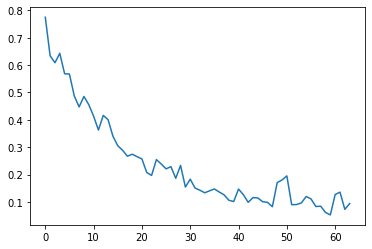

Epoch 1/100
29/29 - 11s - loss: 0.7948 - accuracy: 0.5966 - auc_2: 0.6157 - precision_2: 0.5934 - recall_2: 0.5308 - f1_score: 0.6526 - val_loss: 16.1070 - val_accuracy: 0.4937 - val_auc_2: 0.5000 - val_precision_2: 0.4937 - val_recall_2: 1.0000 - val_f1_score: 0.6610 - 11s/epoch - 377ms/step
Epoch 2/100
29/29 - 7s - loss: 0.6642 - accuracy: 0.6832 - auc_2: 0.7208 - precision_2: 0.6766 - recall_2: 0.6628 - f1_score: 0.6526 - val_loss: 6.5431 - val_accuracy: 0.4937 - val_auc_2: 0.5000 - val_precision_2: 0.4937 - val_recall_2: 1.0000 - val_f1_score: 0.6610 - 7s/epoch - 242ms/step
Epoch 3/100
29/29 - 6s - loss: 0.6429 - accuracy: 0.6832 - auc_2: 0.7350 - precision_2: 0.6766 - recall_2: 0.6628 - f1_score: 0.6526 - val_loss: 0.9450 - val_accuracy: 0.5063 - val_auc_2: 0.6724 - val_precision_2: 0.5000 - val_recall_2: 0.9231 - val_f1_score: 0.6610 - 6s/epoch - 218ms/step
Epoch 4/100
29/29 - 6s - loss: 0.5934 - accuracy: 0.7173 - auc_2: 0.7757 - precision_2: 0.7178 - recall_2: 0.6862 - f1_score

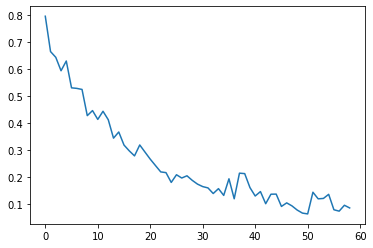

Epoch 1/100
29/29 - 9s - loss: 0.7938 - accuracy: 0.5816 - auc_3: 0.6017 - precision_3: 0.5769 - recall_3: 0.5620 - f1_score: 0.6597 - val_loss: 12.2359 - val_accuracy: 0.4231 - val_auc_3: 0.5000 - val_precision_3: 0.4231 - val_recall_3: 1.0000 - val_f1_score: 0.5946 - 9s/epoch - 309ms/step
Epoch 2/100
29/29 - 7s - loss: 0.6526 - accuracy: 0.6567 - auc_3: 0.7224 - precision_3: 0.6513 - recall_3: 0.6513 - f1_score: 0.6597 - val_loss: 7.3725 - val_accuracy: 0.4231 - val_auc_3: 0.5000 - val_precision_3: 0.4231 - val_recall_3: 1.0000 - val_f1_score: 0.5946 - 7s/epoch - 228ms/step
Epoch 3/100
29/29 - 7s - loss: 0.6237 - accuracy: 0.6709 - auc_3: 0.7380 - precision_3: 0.6629 - recall_3: 0.6744 - f1_score: 0.6597 - val_loss: 2.5266 - val_accuracy: 0.4231 - val_auc_3: 0.7155 - val_precision_3: 0.4231 - val_recall_3: 1.0000 - val_f1_score: 0.5946 - 7s/epoch - 244ms/step
Epoch 4/100
29/29 - 7s - loss: 0.6152 - accuracy: 0.6695 - auc_3: 0.7437 - precision_3: 0.6667 - recall_3: 0.6571 - f1_score: 

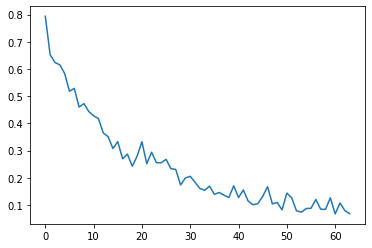

Epoch 1/100
29/29 - 10s - loss: 0.7830 - accuracy: 0.5816 - auc_4: 0.6087 - precision_4: 0.5665 - recall_4: 0.5312 - f1_score: 0.6468 - val_loss: 7.6183 - val_accuracy: 0.5513 - val_auc_4: 0.5000 - val_precision_4: 0.5513 - val_recall_4: 1.0000 - val_f1_score: 0.7107 - 10s/epoch - 352ms/step
Epoch 2/100
29/29 - 7s - loss: 0.7264 - accuracy: 0.6255 - auc_4: 0.6730 - precision_4: 0.6130 - recall_4: 0.5875 - f1_score: 0.6468 - val_loss: 5.0758 - val_accuracy: 0.5513 - val_auc_4: 0.5000 - val_precision_4: 0.5513 - val_recall_4: 1.0000 - val_f1_score: 0.7107 - 7s/epoch - 255ms/step
Epoch 3/100
29/29 - 7s - loss: 0.6613 - accuracy: 0.6511 - auc_4: 0.7218 - precision_4: 0.6350 - recall_4: 0.6350 - f1_score: 0.6468 - val_loss: 3.8238 - val_accuracy: 0.5513 - val_auc_4: 0.5056 - val_precision_4: 0.5513 - val_recall_4: 1.0000 - val_f1_score: 0.7107 - 7s/epoch - 255ms/step
Epoch 4/100
29/29 - 7s - loss: 0.6208 - accuracy: 0.6709 - auc_4: 0.7455 - precision_4: 0.6558 - recall_4: 0.6558 - f1_score:

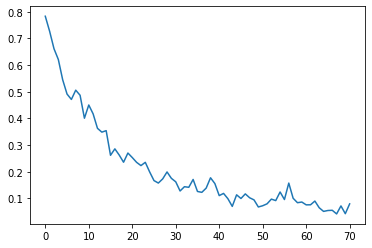

Epoch 1/100
29/29 - 9s - loss: 0.7444 - accuracy: 0.6184 - auc_5: 0.6489 - precision_5: 0.5994 - recall_5: 0.6012 - f1_score: 0.6455 - val_loss: 2.7184 - val_accuracy: 0.5641 - val_auc_5: 0.6166 - val_precision_5: 0.5641 - val_recall_5: 1.0000 - val_f1_score: 0.7213 - 9s/epoch - 321ms/step
Epoch 2/100
29/29 - 7s - loss: 0.6799 - accuracy: 0.6411 - auc_5: 0.7025 - precision_5: 0.6326 - recall_5: 0.5893 - f1_score: 0.6455 - val_loss: 1.0082 - val_accuracy: 0.5513 - val_auc_5: 0.6063 - val_precision_5: 0.6216 - val_recall_5: 0.5227 - val_f1_score: 0.7213 - 7s/epoch - 232ms/step
Epoch 3/100
29/29 - 7s - loss: 0.6730 - accuracy: 0.6440 - auc_5: 0.7114 - precision_5: 0.6254 - recall_5: 0.6310 - f1_score: 0.6455 - val_loss: 1.8746 - val_accuracy: 0.4487 - val_auc_5: 0.5829 - val_precision_5: 0.6000 - val_recall_5: 0.0682 - val_f1_score: 0.7213 - 7s/epoch - 232ms/step
Epoch 4/100
29/29 - 7s - loss: 0.5557 - accuracy: 0.7333 - auc_5: 0.7955 - precision_5: 0.7327 - recall_5: 0.6935 - f1_score: 0

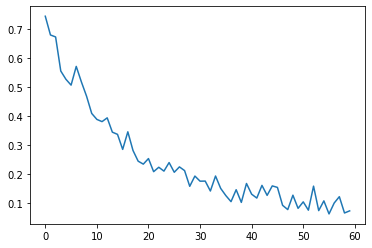

Epoch 1/100
29/29 - 11s - loss: 0.7562 - accuracy: 0.6170 - auc_6: 0.6333 - precision_6: 0.6054 - recall_6: 0.5912 - f1_score: 0.6507 - val_loss: 3.9736 - val_accuracy: 0.4872 - val_auc_6: 0.4951 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.6780 - 11s/epoch - 393ms/step
Epoch 2/100
29/29 - 7s - loss: 0.6756 - accuracy: 0.6582 - auc_6: 0.7034 - precision_6: 0.6523 - recall_6: 0.6235 - f1_score: 0.6507 - val_loss: 2.5624 - val_accuracy: 0.5128 - val_auc_6: 0.6336 - val_precision_6: 0.5128 - val_recall_6: 1.0000 - val_f1_score: 0.6780 - 7s/epoch - 247ms/step
Epoch 3/100
29/29 - 7s - loss: 0.6440 - accuracy: 0.6695 - auc_6: 0.7354 - precision_6: 0.6616 - recall_6: 0.6441 - f1_score: 0.6507 - val_loss: 3.7146 - val_accuracy: 0.5128 - val_auc_6: 0.5556 - val_precision_6: 0.5128 - val_recall_6: 1.0000 - val_f1_score: 0.6780 - 7s/epoch - 255ms/step
Epoch 4/100
29/29 - 7s - loss: 0.6291 - accuracy: 0.6652 - auc_6: 0.7406 - precision_6: 0.6520 - recall_6: 0.6559 - f

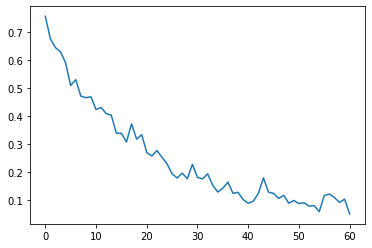

Epoch 1/100
29/29 - 9s - loss: 0.7571 - accuracy: 0.5943 - auc_7: 0.6278 - precision_7: 0.5911 - recall_7: 0.5394 - f1_score: 0.6546 - val_loss: 12.4018 - val_accuracy: 0.4744 - val_auc_7: 0.5000 - val_precision_7: 0.4744 - val_recall_7: 1.0000 - val_f1_score: 0.6435 - 9s/epoch - 319ms/step
Epoch 2/100
29/29 - 7s - loss: 0.7275 - accuracy: 0.6184 - auc_7: 0.6759 - precision_7: 0.6142 - recall_7: 0.5802 - f1_score: 0.6546 - val_loss: 4.3411 - val_accuracy: 0.4744 - val_auc_7: 0.5366 - val_precision_7: 0.4744 - val_recall_7: 1.0000 - val_f1_score: 0.6435 - 7s/epoch - 238ms/step
Epoch 3/100
29/29 - 7s - loss: 0.6564 - accuracy: 0.6766 - auc_7: 0.7213 - precision_7: 0.6657 - recall_7: 0.6735 - f1_score: 0.6546 - val_loss: 3.1492 - val_accuracy: 0.4744 - val_auc_7: 0.5376 - val_precision_7: 0.4744 - val_recall_7: 1.0000 - val_f1_score: 0.6435 - 7s/epoch - 235ms/step
Epoch 4/100
29/29 - 7s - loss: 0.5753 - accuracy: 0.7035 - auc_7: 0.7779 - precision_7: 0.7068 - recall_7: 0.6676 - f1_score: 

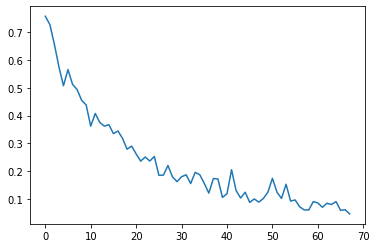

Epoch 1/100
29/29 - 10s - loss: 0.8174 - accuracy: 0.5688 - auc_8: 0.5937 - precision_8: 0.5673 - recall_8: 0.5641 - f1_score: 0.6648 - val_loss: 9.1227 - val_accuracy: 0.6282 - val_auc_8: 0.5000 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_f1_score: 0.5000 - 10s/epoch - 330ms/step
Epoch 2/100
29/29 - 7s - loss: 0.6561 - accuracy: 0.6780 - auc_8: 0.7184 - precision_8: 0.6845 - recall_8: 0.6553 - f1_score: 0.6648 - val_loss: 6.7831 - val_accuracy: 0.3718 - val_auc_8: 0.5000 - val_precision_8: 0.3718 - val_recall_8: 1.0000 - val_f1_score: 0.5421 - 7s/epoch - 235ms/step
Epoch 3/100
29/29 - 7s - loss: 0.6069 - accuracy: 0.6823 - auc_8: 0.7575 - precision_8: 0.6809 - recall_8: 0.6809 - f1_score: 0.6648 - val_loss: 0.8247 - val_accuracy: 0.6795 - val_auc_8: 0.6647 - val_precision_8: 0.7500 - val_recall_8: 0.2069 - val_f1_score: 0.5421 - 7s/epoch - 235ms/step
Epoch 4/100
29/29 - 7s - loss: 0.6132 - accuracy: 0.6794 - auc_8: 0.7590 - precision_8: 0.6888 - recall_8: 0.6496 - f

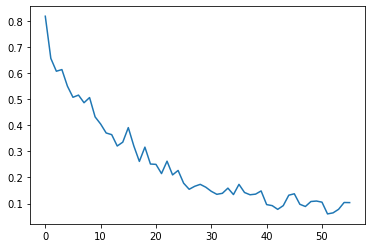

Epoch 1/100
29/29 - 9s - loss: 0.8060 - accuracy: 0.5745 - auc_9: 0.5992 - precision_9: 0.5667 - recall_9: 0.5436 - f1_score: 0.6559 - val_loss: 5.8733 - val_accuracy: 0.4615 - val_auc_9: 0.5000 - val_precision_9: 0.4615 - val_recall_9: 1.0000 - val_f1_score: 0.6316 - 9s/epoch - 318ms/step
Epoch 2/100
29/29 - 7s - loss: 0.6755 - accuracy: 0.6411 - auc_9: 0.6931 - precision_9: 0.6282 - recall_9: 0.6483 - f1_score: 0.6559 - val_loss: 0.9827 - val_accuracy: 0.5769 - val_auc_9: 0.5552 - val_precision_9: 0.5517 - val_recall_9: 0.4444 - val_f1_score: 0.6316 - 7s/epoch - 235ms/step
Epoch 3/100
29/29 - 7s - loss: 0.6512 - accuracy: 0.6667 - auc_9: 0.7248 - precision_9: 0.6708 - recall_9: 0.6221 - f1_score: 0.6559 - val_loss: 1.4795 - val_accuracy: 0.4359 - val_auc_9: 0.6237 - val_precision_9: 0.4459 - val_recall_9: 0.9167 - val_f1_score: 0.6316 - 7s/epoch - 235ms/step
Epoch 4/100
29/29 - 7s - loss: 0.6603 - accuracy: 0.6610 - auc_9: 0.7235 - precision_9: 0.6549 - recall_9: 0.6453 - f1_score: 0

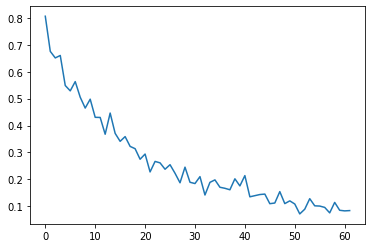

In [5]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_body_model = RCNN(n_features, None, n_length, n_outputs)
    history = rcnn_binary_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=25)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_binary_body_model.save(model_path / 'body_binary_rcnn.h5')

#### Training performance

In [6]:
body_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_rcnn_train_results

{'Accuracy': 0.9787137389183045,
 'ROC/AUC': 0.9970575630664825,
 'Precision': 0.9802907943725586,
 'Recall': 0.975749135017395,
 'F1-score': 0.6534584581851959}

#### Validation performance

In [7]:
body_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_rcnn_val_results

{'Accuracy': 0.6385589063167572,
 'ROC/AUC': 0.7303238213062286,
 'Precision': 0.6369596898555756,
 'Recall': 0.7135727137327195,
 'F1-score': 0.6514892220497132}

#### Predictions and performance on test set

In [8]:
rcnn_binary_body_model = load_model(model_path / 'body_binary_rcnn.h5')
y_pred = rcnn_binary_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_body_model.evaluate(X_test, y_test)
rcnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

9/9 [==============================] - 1s 93ms/step - loss: 1.0738 - accuracy: 0.5620 - auc_7: 0.6098 - precision_7: 0.9078 - recall_7: 0.5447 - f1_score: 0.9234
Accuracy: 56.20% 
ROC/AUC: 0.61 
Precision: 0.91 
Recall: 0.54 
F1 score: 0.92


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

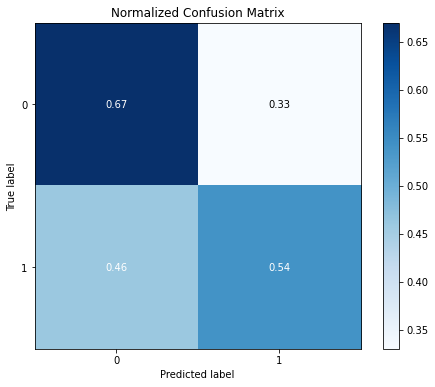

In [9]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

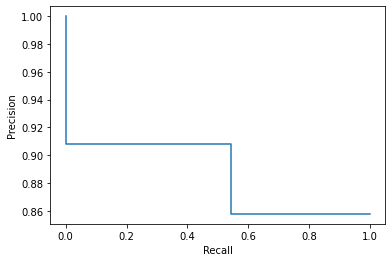

In [10]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## 2. Unimodal Face (Facial Expression + Head Pose)

In [ ]:
X_train, X_test, y_train, y_test = load_dataset('AUs', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

### 2.1 CNN + BiLSTM

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_face_model = CNNLSTM(n_features, None, n_length, n_outputs)
    history = cnnlstm_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_binary_face_model.save(model_path / 'face_binary_cnnlstm.h5')

#### Training performance

In [ ]:
face_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_cnnlstm_train_results

#### Validation performance

In [ ]:
face_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_cnnlstm_val_results

#### Predictions and performance on test set

In [ ]:
cnnlstm_binary_face_model = load_model(model_path / 'face_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_face_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 2.2 RCNN

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_face_model = RCNN(n_features, None, n_length, n_outputs)
    history = rcnn_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_binary_face_model.save(model_path / 'face_binary_rcnn.h5')

#### Training performance

In [ ]:
face_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
face_rcnn_train_results

#### Validation performance

In [ ]:
face_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
face_rcnn_val_results

#### Predictions and performance on test set

In [ ]:
rcnn_binary_face_model = load_model(model_path / 'face_binary_rcnn.h5')
y_pred = rcnn_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_face_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## 3. Multimodal Early Fusion

In [ ]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

### 3.1 CNN + BiLSTM

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_earlyfusion_model = CNNLSTM(n_features, None, n_length, n_outputs)
    history = cnnlstm_binary_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_binary_earlyfusion_model.save(model_path / 'early_binary_cnnlstm.h5')

#### Training performance

In [ ]:
early_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_cnnlstm_train_results

#### Validation performance

In [ ]:
early_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_cnnlstm_val_results

#### Predictions and performance on test set

In [ ]:
cnnlstm_binary_earlyfusion_model = load_model(model_path / 'early_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_earlyfusion_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 3.2 RCNN

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_earlyfusion_model = RCNN(n_features, None, n_length, n_outputs)
    history = rcnn_binary_earlyfusion_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_binary_earlyfusion_model.save(model_path / 'early_binary_rcnn.h5')

#### Training performance

In [ ]:
early_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
early_rcnn_train_results

#### Validation performance

In [ ]:
early_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
early_rcnn_val_results

#### Predictions and performance on test set

In [ ]:
rcnn_binary_earlyfusion_model = load_model(model_path / 'early_binary_rcnn.h5')
y_pred = rcnn_binary_earlyfusion_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_earlyfusion_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## 4. Multimodal Late Fusion

In [ ]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', binary=True, fusion=True)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

In [ ]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', binary=True)
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

In [ ]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### 4.1 CNN + BiLSTM (Concatenation)

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_latefusion_model = CNNLSTM(body_features, face_features, n_length, n_outputs, fusion=True)
    history = cnnlstm_binary_latefusion_model.trainFusioned(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        cnnlstm_binary_latefusion_model.save(model_path / 'late_binary_cnnlstm.h5')

#### Training performance

In [ ]:
late_cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_cnnlstm_train_results

#### Validation performance

In [ ]:
late_cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_cnnlstm_val_results

#### Performance and predictions on test set

In [ ]:
cnnlstm_binary_latefusion_model = load_model(model_path / 'late_binary_cnnlstm.h5')
y_pred = cnnlstm_binary_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = cnnlstm_binary_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 4.2 RCNN (Concatenation)

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
val_accuracy = 0.0
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_latefusion_model = RCNN(body_features, face_features, n_length, n_outputs, fusion=True)
    history = rcnn_binary_latefusion_model.trainFusioned(body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        rcnn_binary_latefusion_model.save(model_path / 'late_binary_rcnn.h5')

#### Training performance

In [ ]:
late_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
late_rcnn_train_results

#### Validation performance

In [ ]:
late_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
late_rcnn_val_results

#### Predictions and performance on test set

In [ ]:
rcnn_binary_latefusion_model = load_model(model_path / 'late_binary_rcnn.h5')
y_pred = rcnn_binary_latefusion_model.predict([body_X_test, face_X_test])
_, acc, auc, precision, recall, f1 = rcnn_binary_latefusion_model.evaluate([body_X_test, face_X_test], y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(8,6))

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

### 4.3 Ensemble

In [ ]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_binary_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_binary_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_binary_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_binary_face_model, train_batches=(face_X_train, y_train), val_batches=(face_X_test, face_y_test))

In [ ]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [ ]:
e = dirichletEnsemble.describe()
cnn_auc.append(round(e, 2))
rnn_auc.append(0)

## Results

In [ ]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion', 'Ensemble']

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, cnn_auc, width, label='CNN + BiLSTM')
rects2 = ax.bar(x + width/2, rnn_auc, width, label='RCNN')

ax.set_title('Baseline AUC (Binary Classification)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()